<a href="https://colab.research.google.com/github/gibeom92/PINN_dispersion/blob/master/2D_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

!pip install --upgrade pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=9ceed7160d123fd4092a3e5c85384f8d18964e9977b34f6c32d607b22553db69
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pyDOE import lhs
from scipy.interpolate import griddata
import time
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
N_C = 10000
N_f = 50000
layers = [3, 64,64,64,64,64,64,64,64,64, 1]

In [4]:
x = np.arange(-50.0, 50.0, 0.5)
y = np.arange(-50.0, 50.0, 0.5)
t = np.arange(0, 10, 0.1)

X, Y = np.meshgrid(x, y)
X, T = np.meshgrid(X, t)
Y, T = np.meshgrid(Y, t)

C_0 = 1 / np.cosh(np.sqrt(X[0]**2+Y[0]**2))

XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
lb = XY_star.min(0); ub = XY_star.max(0)
C_star = C_0.flatten()[:, None]

xy1 = np.hstack((X[0:1, :].T, Y[0:1, :].T, T[0:1, :].T))
CC1 = C_0.flatten()[:,None]
xy2 = np.hstack((X[:, 0:1], Y[:, 0:1], T[:, 0:1]))
xy2[:,0:2] = -1000
CC2 = (np.random.uniform(size=len(t)) * 1.0e-100).flatten()[:,None]
xy3 = np.hstack((X[:, -1:], Y[:, -1:], T[:, -1:]))
xy3[:,0:2] = 1000
CC3 = (np.random.uniform(size=len(t)) * 1.0e-100).flatten()[:,None]

XY_C_train = np.vstack([xy1, xy2, xy3])
XY_f_train = lb + (ub - lb) * lhs(3, N_f)
XY_f_train = np.vstack((XY_f_train, XY_C_train))
C_train = np.vstack([CC1, CC2, CC3])

idx = np.random.choice(XY_C_train.shape[0], N_C, replace=False)
XY_C_train = XY_C_train[idx, :]
C_train = C_train[idx, :]

In [5]:
x_C = tf.convert_to_tensor(XY_C_train[:,0:1])
y_C = tf.convert_to_tensor(XY_C_train[:,1:2])
t_C = tf.convert_to_tensor(XY_C_train[:,2:3])

X_C = tf.stack([x_C, y_C, t_C], axis=1)

In [6]:
class PINN:
  def __init__(self, X_C, C, X_f, layers, lb, ub, wind, K):

    self.dtype = tf.float32

    self.count = 0

    self.x_C = tf.convert_to_tensor(X_C[:,0:1], dtype=self.dtype)
    self.y_C = tf.convert_to_tensor(X_C[:,1:2], dtype=self.dtype)
    self.t_C = tf.convert_to_tensor(X_C[:,2:3], dtype=self.dtype)

    self.x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=self.dtype)   # (n, 1) shape
    self.y_f = tf.convert_to_tensor(X_f[:,1:2], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:,2:3], dtype=self.dtype)

    self.C = tf.convert_to_tensor(C, dtype=self.dtype) 

    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    # neural network
    self.C_model = tf.keras.Sequential()
    self.C_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.C_model.add(tf.keras.layers.Lambda(lambda X: 2.0 * (X - lb)/(ub - lb) - 1.0))
    for node in layers[1:-2]:
      self.C_model.add(tf.keras.layers.Dense(node, activation = 'tanh', 
                                             kernel_initializer = 'glorot_normal'))  # glorot: xavier initializer
    self.C_model.add(tf.keras.layers.Dense(layers[-2], activation = 'sigmoid', 
                                           kernel_initializer = 'glorot_normal',
                                           kernel_constraint = tf.keras.constraints.NonNeg(), 
                                           bias_constraint = tf.keras.constraints.NonNeg())) 
    self.C_model.add(tf.keras.layers.Dense(layers[-1], activation = 'elu', 
                                           kernel_initializer = 'he_normal'))

  def net_C(self):
    XY_C = tf.stack([self.x_C, self.y_C, self.t_C], axis=1)
    C = self.C_model(XY_C)
    return C

  def cal_wind(self, x, y, t):
    wind = 5
    return wind

  def cal_K_x(self, x, t):
    K_x = (abs(x) + 1) * 1
    return K_x

  def cal_K_y(self, y, t):
    K_y = (abs(y) + 1) * 1
    return K_y

  def net_f(self):
    with tf.GradientTape(persistent = True) as tape:
      tape.watch(self.x_f)
      tape.watch(self.y_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.x_f, self.y_f, self.t_f], axis=1)
      
      C = self.C_model(X_f)
      C_t = tape.gradient(C, self.t_f)
      C_x = tape.gradient(C, self.x_f)
      C_xx = tape.gradient(C_x, self.x_f)
      C_y = tape.gradient(C, self.y_f)
      C_yy = tape.gradient(C_y, self.y_f)

      wind = self.cal_wind(self.x_f, self.y_f, self.t_f)

      C_wind = C * wind

      C_wind_dx = tape.gradient(C_wind, self.x_f)
      C_wind_dy = tape.gradient(C_wind, self.y_f)

      K_x = self.cal_K_x(self.x_f, self.t_f)
      K_y = self.cal_K_y(self.y_f, self.t_f)

      C_K_x = K_x * C_x
      C_K_y = K_y * C_y      

      C_K_x_x = tape.gradient(C_K_x, self.x_f)
      C_K_y_y = tape.gradient(C_K_y, self.y_f)

    del tape
    return C_t + C_wind_dx + C_wind_dy - (C_K_x_x + C_K_y_y)

  # Loss
  @tf.function
  def loss(self):
    f_pred = self.net_f()
    C_pred = self.net_C()
    return tf.reduce_mean(tf.square(self.C - C_pred)) + tf.reduce_mean(tf.square(f_pred))

  # training
  def get_weights(self):
    w = []
    for layer in self.C_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.C_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def step(self):
    self.count += 1
    return self.count

  def train(self):
    def optim(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss = self.loss()
      grad = tape.gradient(loss, self.C_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat = tf.concat(grad_flat, 0)
      self.step()
      if self.count % 100 == 0:
        print(self.count, ': ', loss)
      return loss, grad_flat

    return tfp.optimizer.lbfgs_minimize(
        optim, self.get_weights(),
        num_correction_pairs = 50, 
        max_iterations = 2000,
        parallel_iterations = 128) #, f_relative_tolerance = 0.0005) 
        #f_relative_tolerance = 0.001, 
        #tolerance = 0.001) # 1.0 * np.finfo(float).eps


In [7]:
model = PINN(XY_C_train, C_train, XY_f_train, layers, lb, ub, wind, K)

with tf.device('/gpu:0'):
  start_time = time.time()
  result = model.train()
  elapsed = time.time() - start_time
  print('time: ', elapsed)

100 :  tf.Tensor(0.00032097579, shape=(), dtype=float32)
200 :  tf.Tensor(0.00031793807, shape=(), dtype=float32)
300 :  tf.Tensor(0.00031531442, shape=(), dtype=float32)
400 :  tf.Tensor(0.0003112817, shape=(), dtype=float32)
500 :  tf.Tensor(0.00029814983, shape=(), dtype=float32)
600 :  tf.Tensor(0.00027291133, shape=(), dtype=float32)
700 :  tf.Tensor(0.00024348572, shape=(), dtype=float32)
800 :  tf.Tensor(0.00022341637, shape=(), dtype=float32)
900 :  tf.Tensor(0.0002158036, shape=(), dtype=float32)
1000 :  tf.Tensor(0.00021083104, shape=(), dtype=float32)
1100 :  tf.Tensor(0.00019073111, shape=(), dtype=float32)
1200 :  tf.Tensor(0.00016351131, shape=(), dtype=float32)
1300 :  tf.Tensor(0.00011027061, shape=(), dtype=float32)
1400 :  tf.Tensor(7.272941e-05, shape=(), dtype=float32)
1500 :  tf.Tensor(4.319077e-05, shape=(), dtype=float32)
1600 :  tf.Tensor(2.7373682e-05, shape=(), dtype=float32)
1700 :  tf.Tensor(2.0577703e-05, shape=(), dtype=float32)
1800 :  tf.Tensor(1.5909256

In [8]:
x = np.arange(-20.0, 20.0, 0.2)
y = np.arange(-20.0, 20.0, 0.2)
t = np.arange(0, 3.0, 0.3)

X, Y = np.meshgrid(x, y)
X, T = np.meshgrid(X, t)
Y, T = np.meshgrid(Y, t)

XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

with tf.device('/gpu:0'):
  C_pred = model.C_model(XY_star)
  #result = griddata(XY_star, C_pred, (X, Y, T))

In [9]:
temp = tf.reshape(C_pred, [10, 200, 200])

X, Y = np.meshgrid(x, y)

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
images_dir = '/content/gdrive/My Drive/Colab Notebooks/PINN'

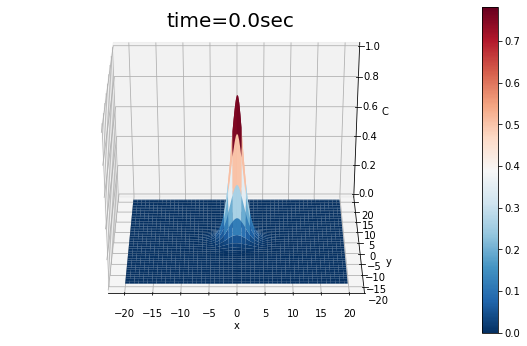

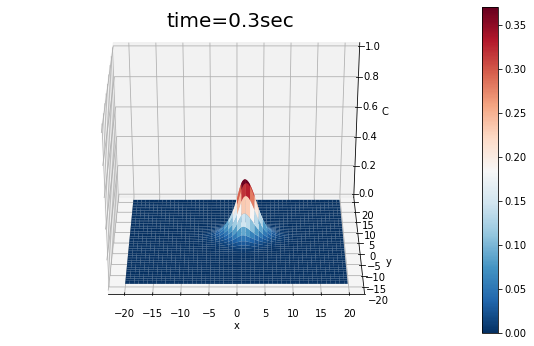

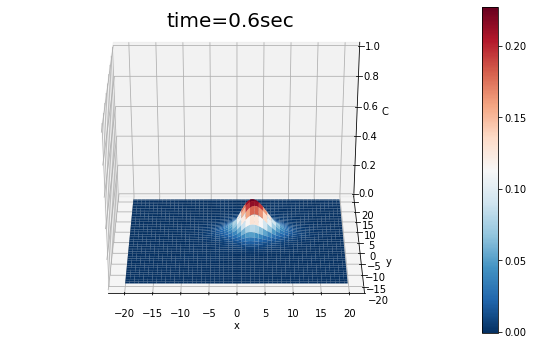

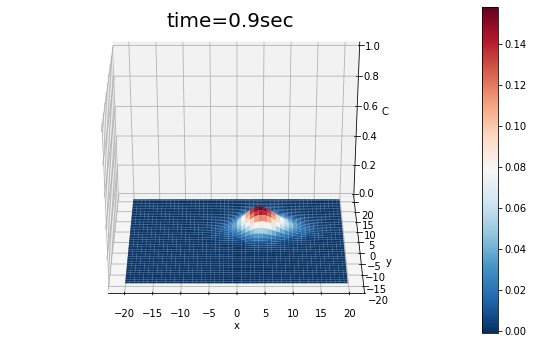

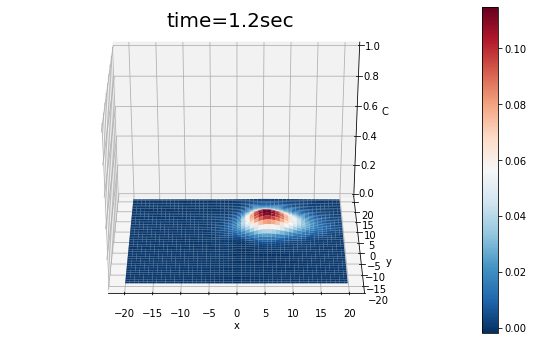

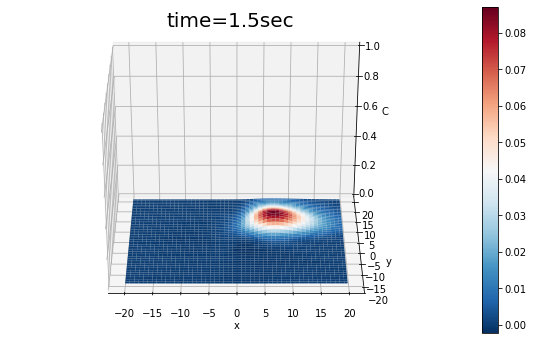

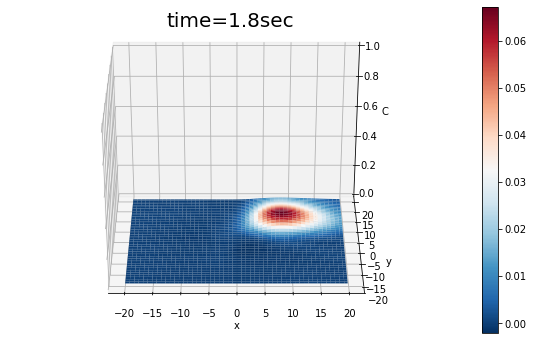

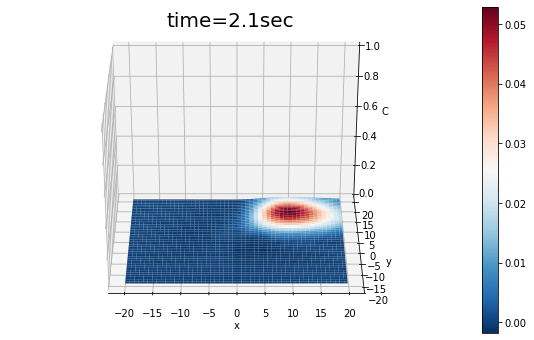

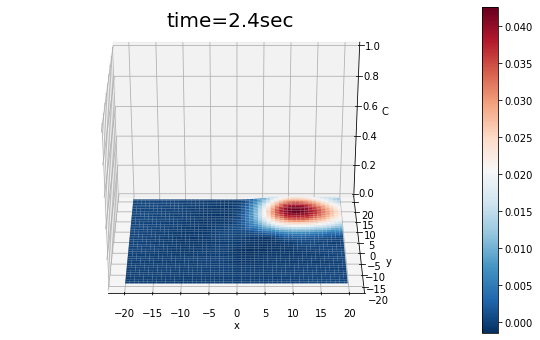

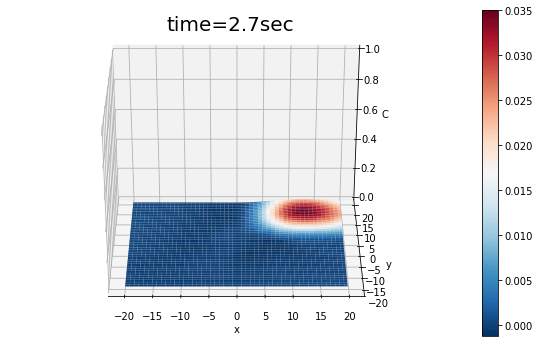

In [12]:

fsize = 10
for i in range(10):
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(1, 1, 1, projection='3d')             # 3d axes instance
  ax.set_title('time='+str(round(i * 0.3,1))+'sec', size=20)       
  ax.set_xlabel('x', size=fsize)                            
  ax.set_ylabel('y', size=fsize)                            
  ax.set_zlabel('C', size=fsize)   
  ax.set_zlim3d(0, 1)
  surf = ax.plot_surface(X, Y, temp[i].numpy(),          # data values (2D Arryas)
                        #rstride=2,                   # row step size
                        #cstride=2,                  # column step size
                        cmap=cm.RdBu_r,       # colour map
                        linewidth=1,              # wireframe line width
                        antialiased=True, alpha = 1)    
  ax.view_init(elev=30,azim=-90) 
  plt.colorbar(surf)
  plt.savefig(f"{images_dir}/3-"+str(i)+".png")